In [112]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import random
import numpy as np
from PIL import Image

batch_size = 32 # Batch size for training model
num_classes = 102 # Number of classes in Flowers-102
learning_rate = 0.001 # Learning rate for the optimiser
num_epochs = 300 # Number of epochs
patience = 10  # Patience for early stopping


In [113]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Check if a CUDA-compatible GPU is available
device
torch.cuda.empty_cache()

In [114]:
print("Process started")

# Load the dataset and preprocessing

# Keeping the original images, before the transformation
original_transform = transforms.Compose([ 
    transforms.Resize((256, 256)), 
    transforms.ToTensor() 
])

original_dataset = torchvision.datasets.Flowers102(root='./data', split='train', transform=original_transform, download=True) #

# Transforming images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1325,), std=(0.3105,)),
])

# Load the dataset and split it into training, validation, and test sets
full_dataset = torchvision.datasets.Flowers102(root='./data', split='train', transform=transform, download=True)

# 80-20 train-validation split
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = torchvision.datasets.Flowers102(root='./data', split='test', transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Process started


In [115]:
# Define the CNN model
class CNNModel(nn.Module):
    """
    CNNModel is a model class for the Convolutional Neural Network Model, inheriting from nn.Module.
    This model has various convolutional layers, activation functions, pooling layers, batch normalization, 
    fully connected layers, and dropout applied for regularization.

    Methods:
    __init__()
        Initializes the CNN model with defined layers.
    forward(x)
        Defines the forward pass of the model.
    """
    def __init__(self):
        super(CNNModel, self).__init__()
        # Defining the sequence of layers
        self.layers = nn.Sequential(
            # 1st convolutional layer
            nn.Conv2d(3, 150, 5, stride=1, padding=2, bias=False),
            # 2nd depthwise convolutional layer
            nn.Conv2d(150, 150, 5, stride=1, padding=2, bias=False, groups=150),
            # ReLU activation
            nn.ReLU(),
            # Max pooling layer with 16x16 kernel
            nn.MaxPool2d(16),
            # Batch normalization for 150 feature maps
            nn.BatchNorm2d(150),

            # 3rd convolutional layer
            nn.Conv2d(150, 300, 5, stride=1, padding=2, bias=False),
            # 4th depthwise convolutional layer
            nn.Conv2d(300, 300, 5, stride=1, padding=2, bias=False, groups=300),
            # ReLU activation
            nn.ReLU(), 
            # Max pooling layer with 8x8 kernel
            nn.MaxPool2d(8),
            # Batch normalization for 300 feature maps
            nn.BatchNorm2d(300),
            # Adaptive average pooling layer to reduce each feature map to 1x1
            nn.AdaptiveAvgPool2d((1, 1)),
            
            # Flatten the feature maps
            nn.Flatten(),
            # Fully connected layers with 300 input features and 512 output features
            nn.Linear(300, 512),
            # Sigmoid activation function
            nn.Sigmoid(),
            # Dropout function activation
            nn.Dropout(0.5),
            # Fully connected layers with 512 input features and 102 output features
            nn.Linear(512, num_classes),
            # LogSoftmax activation function for output layer
            nn.LogSoftmax(1)
        )

    def forward(self, input_tensor):
        """
        Defines the forward pass of the model.
        
        Parameters
        x : torch.Tensor
            Input tensor to the model.
        Returns
        torch.Tensor
            Output tensor after passing through the layers of the model.
        """
        output_tensor = self.layers(input_tensor)
        return output_tensor

# Create model instance and move to device
model = CNNModel().to(device)
print(model)

CNNModel(
  (layers): Sequential(
    (0): Conv2d(3, 150, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): Conv2d(150, 150, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=150, bias=False)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=16, stride=16, padding=0, dilation=1, ceil_mode=False)
    (4): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(150, 300, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (6): Conv2d(300, 300, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=300, bias=False)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
    (9): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): AdaptiveAvgPool2d(output_size=(1, 1))
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=300, out_features=512, bias=True)
    (13): Sigmoid()
    (14): Dropout(p=0.5, inplace

In [116]:
# Define loss function and optimiser
criterion = nn.NLLLoss() # Using Negative Log Likelihood Loss for classification
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate) # Using Adam optimiser with model parameters and the learning rate


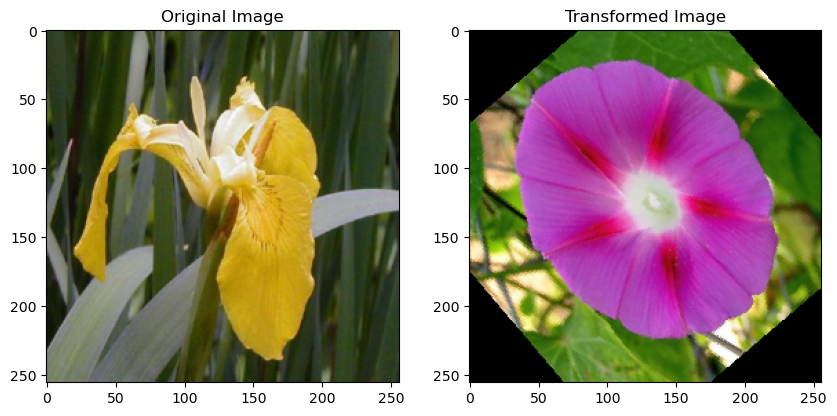

In [117]:
# Get the original image
random_idx = random.randint(0, len(original_dataset) - 1)
original_image, _ = original_dataset[random_idx]

# Display the original image
original_img = original_image.numpy()
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(original_img, (1, 2, 0)))
plt.title("Original Image")

# Get the transformed image
transformed_image, _ = train_dataset[random_idx]

# Unnormalise the transformed image
transformed_img = transformed_image.numpy()
transformed_img = transformed_img * 0.3105 + 0.1325  # Unnormalise images using the mean amd the std 

# Display the transformed image
plt.subplot(1, 2, 2)
plt.imshow(np.transpose(transformed_img, (1, 2, 0)))
plt.title("Transformed Image")

# Show the images
plt.show()

In [118]:
# Training function with validation and early stopping
def train(num_epochs, patience):
    """
    Train the CNN model with early stopping based on validation loss.

    Parameters
    num_epochs : int
        Number of epochs to train the model.
    patience : int
        Number of epochs to wait for improvement in validation loss before early stopping.

    The function trains this model on the training set, evaluates the model's performance on the validation set,
    and eventually performs early stopping if no improvement in validation loss is observed within a prespecified number of epochs.
    """
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        run_loss = 0.0 
        total_correct = 0
        total_images = 0

        for i, (x, y) in enumerate(train_loader, 0):
            x, y = x.to(device), y.to(device)
            optimiser.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimiser.step()

            run_loss += loss.item() 

            # Calculate accuracy
            predicted = torch.max(outputs, 1)[1]
            total_correct += (predicted == y).sum().item()
            total_images += y.size(0)

            if (i + 1) % 32 == 0:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {run_loss / 32:.3f}')
                run_loss = 0.0  

        # Calculate accuracy at the end of each epoch
        accuracy = 100 * total_correct / total_images
        print(f'Accuracy of the network on the {total_images} training images: {accuracy:.1f} %')

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                loss = criterion(outputs, y)
                val_loss += loss.item()

        if len(val_loader) > 0:
            val_loss /= len(val_loader)
            print('Validation loss after epoch %d: %.3f' % (epoch + 1, val_loss))

        # Early stopping tecnique
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  
            # Save the best model
            torch.save(model.state_dict(), 'best_model_weights.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping triggered')
            break

# Test function
def test_model():
    """
    Test the CNN model on the test dataset.

    The function loads the best model saved during training, evaluates the model on the test dataset,
    and prints the accuracy of the model.
    """
    model.load_state_dict(torch.load('best_model_weights.pth'))  # Load the best model
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation for testing
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)  # Forward pass
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct / total:.1f} %')

# Run training and testing
train(num_epochs, patience)
test_model()
print("Process finished")
final_model_version = model.load_state_dict(torch.load('best_model_weights.pth'))
torch.save(model, "model.pth")
model_itself = torch.load("model.pth")

Accuracy of the network on the 918 training images: 2.0 %
Validation loss after epoch 1: 4.613
Accuracy of the network on the 918 training images: 4.5 %
Validation loss after epoch 2: 4.233
Accuracy of the network on the 918 training images: 8.7 %
Validation loss after epoch 3: 3.963
Accuracy of the network on the 918 training images: 12.3 %
Validation loss after epoch 4: 3.736
Accuracy of the network on the 918 training images: 13.5 %
Validation loss after epoch 5: 3.482
Accuracy of the network on the 918 training images: 18.0 %
Validation loss after epoch 6: 3.360
Accuracy of the network on the 918 training images: 22.2 %
Validation loss after epoch 7: 3.218
Accuracy of the network on the 918 training images: 25.3 %
Validation loss after epoch 8: 2.995
Accuracy of the network on the 918 training images: 33.7 %
Validation loss after epoch 9: 3.019
Accuracy of the network on the 918 training images: 32.0 %
Validation loss after epoch 10: 2.857
Accuracy of the network on the 918 trainin

In [ ]:
print(final_model_version)

In [67]:
print(model_itself)

CNNModel(
  (layers): Sequential(
    (0): Conv2d(3, 150, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): Conv2d(150, 150, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=150, bias=False)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=16, stride=16, padding=0, dilation=1, ceil_mode=False)
    (4): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(150, 300, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (6): Conv2d(300, 300, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=300, bias=False)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
    (9): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): AdaptiveAvgPool2d(output_size=(1, 1))
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=300, out_features=512, bias=True)
    (13): Sigmoid()
    (14): Dropout(p=0.5, inplace